In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import pickle
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [7]:
df = pd.read_csv(r'C:/Users/Supalerk/Desktop/game_analytics/game-analytics/game_client/game_data.csv',
                names= ['player_name','score','player_x','player_y','enemy_count','coin_count','bullet_count','miss_bullet_count','timestamp'])
# df.set_index('game_id',inplace=True)
df.head()

,player_name,score,player_x,player_y,enemy_count,coin_count,bullet_count,miss_bullet_count,timestamp
0,PLAYER,12,447.421286,305.396896,7,5,8,1,1624194794
1,PLAYER,7,404.902825,432.454195,5,2,7,2,1624194825
2,PLAYER,7,404.902825,432.454195,5,2,7,2,1624194825
3,PLAYER,2,368.542959,239.788783,1,1,2,1,1624195135
4,PLAYER,4,417.820000,253.350000,2,2,3,1,1624195147


In [35]:
col = ['enemy_count', 'coin_count']
df2 = df[col]

In [36]:
mm_scaler = MinMaxScaler()
mm_scaler.fit(df2)
df2_tf = pd.DataFrame(mm_scaler.transform(df2), index=df.index, columns=col)

DIR_TRANSFORM_MODEL = './scaler_model.pkl'
pickle.dump(mm_scaler, open(DIR_TRANSFORM_MODEL,'wb'))

In [37]:
kmeans = KMeans(n_clusters = 4, random_state=0)
kmeans.fit(df2_tf[col])
df2['cluster'] = kmeans.predict(df2_tf[col])
df2.head()

,enemy_count,coin_count,cluster
0,7,5,1
1,5,2,1
2,5,2,1
3,1,1,1
4,2,2,1


In [41]:
DIR_PREDICTION_MODEL = './kmeans_model.pkl'
pickle.dump(kmeans, open(DIR_PREDICTION_MODEL,'wb'))

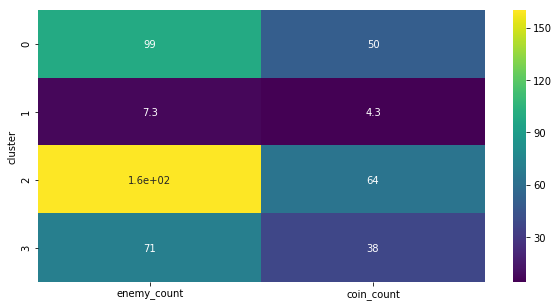

In [38]:
plt.figure(figsize=(10,5))
sns.heatmap(df2.groupby('cluster').mean(), cmap='viridis', annot=True )

In [39]:
X = df2[col]
y = df2['cluster']

In [20]:
# y_unique_lst = sorted(y.unique().tolist())
# i = 0
# fig, ax = plt.subplots(len(y_unique_lst), 1, figsize=(20,60), dpi = 300)
# for cluster in y_unique_lst:
#     new_y = y == cluster
#     dtree = DecisionTreeClassifier(criterion = 'entropy', max_depth=4)
#     dtree.fit(X, new_y)
#     tree.plot_tree(
#             dtree,
#             feature_names = col,
#             # class_names = (new_y * cluster).astype(str),
#             filled = True,
#             ax = ax[i]
#   );
#     ax[i].set_title(f'--------------------- CLUSTER NUMBER : {cluster} --------------------- ')
#     i+=1
# fig.savefig('./dendrogram_one_vs_rest.png')

[Text(225.533,291.515,'enemy_count <= 44.5\nentropy = 1.85\nsamples = 16\nvalue = [4, 7, 2, 3]'),
 Text(112.767,208.225,'entropy = 0.0\nsamples = 7\nvalue = [0, 7, 0, 0]'),
 Text(338.3,208.225,'coin_count <= 40.5\nentropy = 1.53\nsamples = 9\nvalue = [4, 0, 2, 3]'),
 Text(225.533,124.935,'entropy = 0.0\nsamples = 3\nvalue = [0, 0, 0, 3]'),
 Text(451.067,124.935,'enemy_count <= 135.5\nentropy = 0.918\nsamples = 6\nvalue = [4, 0, 2, 0]'),
 Text(338.3,41.645,'entropy = 0.0\nsamples = 4\nvalue = [4, 0, 0, 0]'),
 Text(563.833,41.645,'entropy = 0.0\nsamples = 2\nvalue = [0, 0, 2, 0]')]

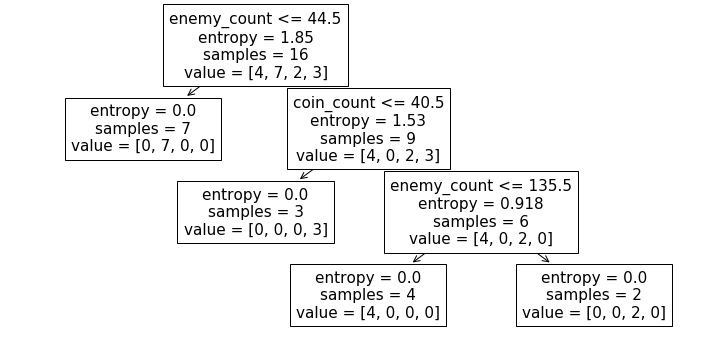

In [40]:
plt.figure(figsize=(12,6))
dtree = DecisionTreeClassifier(criterion = 'entropy')
dtree.fit(X, y)
tree.plot_tree(
            dtree,
            feature_names = col)

0     0
1     0
2     0
3     0
4     0
5     3
6     2
7     2
8     1
9     1
10    0
11    3
12    1
13    0
14    1
15    1
Name: cluster, dtype: int32

In [ ]:
DIR_TRANSFORM_MODEL = './scaler_model.pkl'
pickle.dump(mm_scaler, open(DIR_TRANSFORM_MODEL,'wb'))

In [64]:
scaler

MinMaxScaler()

In [75]:
test = df2.iloc[2,:-1].values.tolist()
test

[5, 2]

In [80]:
seg_dict = {0:'Hardcore achiever'
           ,1:'Casual achiever'
           ,2:'Hardcore killer'
           ,3:'Casual killer'
           }
scaler_model = pickle.load( open(DIR_TRANSFORM_MODEL,'rb'))
kmeans_model = pickle.load(open(DIR_PREDICTION_MODEL, 'rb'))
scaler_score = scaler_model.transform(np.array(test).reshape(1,-1))
player_type = kmeans_model.predict(test2)
seg_dict[player_type[0]]

'Casual achiever'